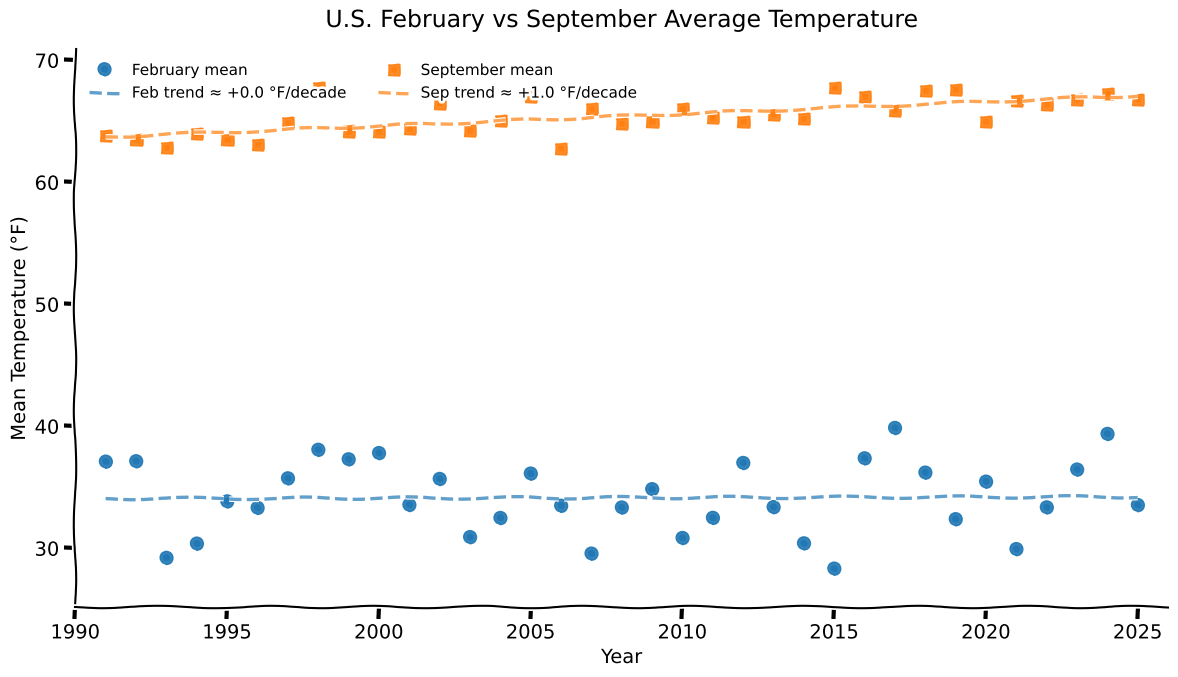

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import logging

# Prevent font warnings
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

filename = 'data.csv'
df = pd.read_csv(filename)
df.columns = df.columns.str.strip()

# Make sure we have a proper datetime column or Month column
# Option 1: If you have separate Year + Month columns
if 'Month' in df.columns:
    # Filter only January
    df_jan = df[df['Month'].astype(str).str.strip().isin(['9'])] #here*
    
# Option 2: If you have a Date/datetime column instead (more robust)
elif 'Date' in df.columns or df.columns.str.contains('date', case=False).any():
    date_col = next(c for c in df.columns if 'date' in c.lower())
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df_jan = df[df[date_col].dt.month == 1]
    
# Option 3: If month is numeric but called something else (e.g. 'month', 'm')
else:
    month_col = next((c for c in df.columns if 'month' in c.lower()), None)
    if month_col:
        df_jan = df[df[month_col].astype(str).str.strip().isin(['1', '01'])]
    else:
        print("Cannot find month information — please check your CSV columns")
        df_jan = df  # fallback

# Now compute January average per year
january_avg = (
    df_jan.groupby('Year', as_index=False)['Temperature']
          .mean()
          .rename(columns={'Temperature': 'January_Mean_Temperature'})
)

january_avg['January_Mean_Temperature'] = january_avg['January_Mean_Temperature'].round(2)

years = january_avg['Year']
temps = january_avg['January_Mean_Temperature']

slope, intercept = np.polyfit(years, temps, 1)
trend_line = slope * years + intercept
trend_label = f'Linear trend ≈ {10*slope:+.1f} °F/decade'

# --- XKCD STYLE ---
with plt.xkcd(scale=1.2, length=120, randomness=2):
    fig, ax = plt.subplots(figsize=(11, 6), dpi=100)

    ax.plot(years, temps, 'o', markersize=9, color='darkblue', alpha=0.8, label='January mean')
    ax.plot(years, trend_line, '--', lw=2.5, color='darkred', alpha=0.8, label=trend_label)

    ax.set_title('U.S. Febryary Average Temperature', fontsize=16, pad=14)
    ax.set_xlabel('Year', fontsize=13)
    ax.set_ylabel('Mean Temperature (°F)', fontsize=13)
    ax.set_xlim(1990, 2026)
    ax.set_xticks(range(1990, 2026 + 1, 5))  # every 5 years
    ax.legend(loc='upper left', fontsize=11, frameon=False)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

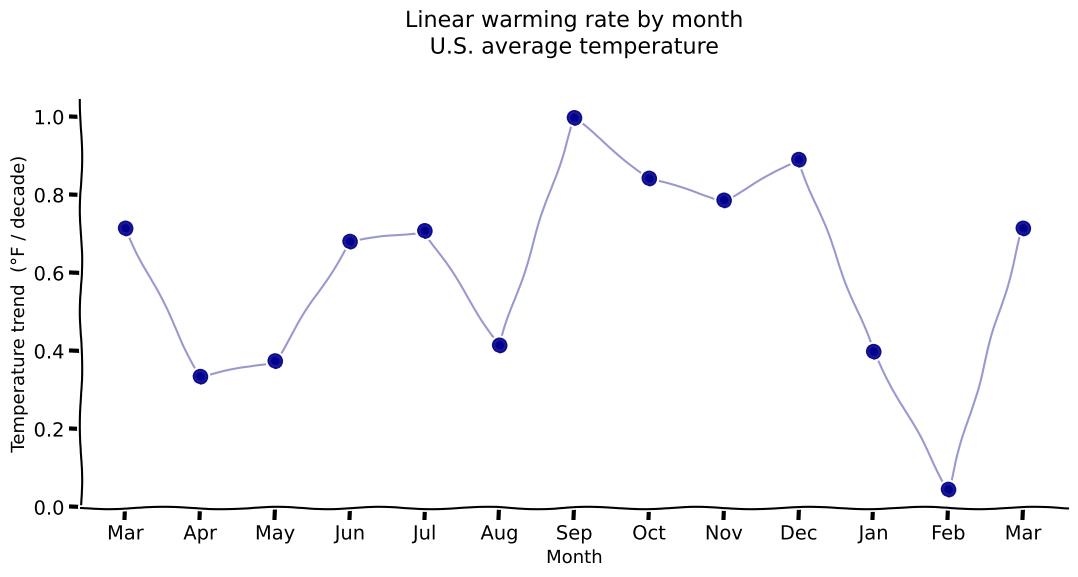

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import logging

logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

filename = 'data.csv'
df = pd.read_csv(filename)
df.columns = df.columns.str.strip()

slopes = []

month_order = [3,4,5,6,7,8,9,10,11,12,1,2,3]
month_labels = ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar']

month_col = None
for possible in ['Month', 'month', 'Mon', 'm', 'MonthNum']:
    if possible in df.columns:
        month_col = possible
        break

if month_col is None:
    date_col = None
    for c in df.columns:
        if 'date' in c.lower():
            date_col = c
            break
    
    if date_col:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        has_datetime = True
    else:
        print("Could not find a Month or Date column — please check your CSV")
        exit(1)
else:
    has_datetime = False
    df[month_col] = df[month_col].astype(str).str.strip()

for m in month_order:
    if has_datetime:
        df_month = df[df[date_col].dt.month == m]
    else:
        month_strs = [str(m), f"{m:02d}"]
        df_month = df[df[month_col].isin(month_strs)]
    
    if df_month.empty:
        print(f"No data for month {m} — skipping")
        slopes.append(np.nan)
        continue
    
    monthly_avg = (
        df_month.groupby('Year', as_index=False)['Temperature']
                .mean()
                .rename(columns={'Temperature': 'Mean_Temp'})
    )
    
    if len(monthly_avg) < 3:
        print(f"Too few years for month {m} — skipping fit")
        slopes.append(np.nan)
        continue
    
    years = monthly_avg['Year'].values
    temps = monthly_avg['Mean_Temp'].values
    
    # Linear fit
    slope, intercept = np.polyfit(years, temps, 1)
    slopes.append(slope)

slopes_decade = [s * 10 if not np.isnan(s) else np.nan for s in slopes]

with plt.xkcd(scale=1.2, length=120, randomness=2):
    fig, ax = plt.subplots(figsize=(11, 6), dpi=100)  

    # Plot points
    valid = ~np.isnan(slopes_decade)
    ax.plot(np.arange(len(month_order))[valid], np.array(slopes_decade)[valid],
            'o', markersize=10, color='darkblue', alpha=0.9, zorder=3)

    ax.plot(range(len(month_order)), slopes_decade, '-', color='darkblue', alpha=0.4, lw=1.5, zorder=2)

    ax.set_title('Linear warming rate by month\nU.S. average temperature\n', 
                 fontsize=16, pad=14)
    
    ax.set_xlabel('Month', fontsize=13)
    ax.set_ylabel('Temperature trend  (°F / decade)', fontsize=13)
    
    ax.set_xticks(range(len(month_order)))
    ax.set_xticklabels(month_labels, rotation=0, ha='center')
    
    ax.grid(True, alpha=0.15, axis='y')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.axhline(0, color='gray', lw=0.8, alpha=0.5, zorder=1)
    
    
    plt.tight_layout()
    plt.show()